In [220]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load event file
filename = "/Users/ogilbert/Desktop/PhD/Courses/ASTRO532/cluster_assignment/13468/primary/acisf13468N003_evt2.fits.gz"
with fits.open(filename) as hdul:
    events = hdul["EVENTS"].data

x = events["x"]
y = events["y"]

# Histogram events to make image
nbins = 2048  # 4096 pixels ~ full field; 8192 gives finer sampling
xrange = [x.min(), x.max()]
yrange = [y.min(), y.max()]
img, xedges, yedges = np.histogram2d(x, y, bins=nbins, range=[xrange, yrange])

cutout = img.T[700:1200,1150:1650]









def net_flux(image, target_pos, noise_pos, radius=40, noise_radius=50, if_plot=False, verbose=False):
    '''
    Calculates the approximate flux of a source by substracting the noise of its nearby background

    Parameters:
    image: image data with the source (2D array)
    target_pos: list of position of the source (e.g. [100, 200])
    radius: approximate radius of the source object
    if_plot: boolean, if True, plot only the flux within the radius
    
    Returns the estimated flux of the source
    '''
    x0, y0 = target_pos[0], target_pos[1]
    x1, y1 = noise_pos[0], noise_pos[1]
    pixels_inside, pixels_noise = 0, 0
    within_flux = 0#np.zeros(image[y0-2*radius:y0+2*radius, x0-2*radius:x0+2*radius].shape)
    noise_flux = 0#np.zeros(image[y1-2*noise_radius:y1+2*noise_radius, x1-2*noise_radius:x1+2*noise_radius].shape)
    for y, line in enumerate(image[y0-2*radius:y0+2*radius, x0-2*radius:x0+2*radius]):
        for x, val in enumerate(line):
            if np.sqrt((x-2*radius-1)**2+(y-2*radius)**2)<=radius:
                within_flux+=val#[y, x] = val
                pixels_inside += 1
    for y, line in enumerate(image[y1-2*noise_radius:y1+2*noise_radius, x1-2*noise_radius:x1+2*noise_radius]):
        for x, val in enumerate(line):
            if np.sqrt((x-2*noise_radius-1)**2+(y-2*noise_radius)**2)<=noise_radius:
                noise_flux+=val#[y, x] = val
                pixels_noise += 1
    
    

    flux_within = within_flux#np.sum(within_flux)
    flux_noise = noise_flux#np.sum(noise_flux)
    flux_source = flux_within - (flux_noise/pixels_noise)*pixels_inside
    if verbose:
        print(f'-----------------------------')
        print(f'raw flux source: {flux_within}')
        print(f'flux noise: {flux_noise}')
        print(f'net flux source: {flux_source}')
        print(f'-----------------------------')
    if if_plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.suptitle(f'Net flux of source: {flux_source}')

        circle1 = plt.Circle((2*radius+1, 2*radius), radius, color='white', fill=False)
        circle2 = plt.Circle((2*noise_radius+1, 2*noise_radius), noise_radius, color='white', fill=False)
        circle3 = plt.Circle(tuple(target_pos), radius, color='white', fill=False)
        circle4 = plt.Circle(tuple(noise_pos), noise_radius, color='white', fill=False)
        ax1.set_title(label=f'Raw flux of source: {flux_within}\nNumber of pixels: {pixels_inside}')
        ax2.set_title(label=f'Flux noise: {flux_noise}\nNumber of pixels: {pixels_noise}\nNoise density: {flux_noise/pixels_noise}')
        ax1.imshow(image[y0-2*radius:y0+2*radius, x0-2*radius:x0+2*radius], origin='lower')
        ax2.imshow(image[y1-2*noise_radius:y1+2*noise_radius, x1-2*noise_radius:x1+2*noise_radius], origin='lower')
        ax3.imshow(image, origin='lower')
        ax1.add_patch(circle1)
        ax2.add_patch(circle2)
        ax3.add_patch(circle3)
        ax3.add_patch(circle4)
        plt.show()
    return flux_source
fluxes = []
radii = np.linspace(5,250,245)
for r in tqdm(radii):
    fluxes.append(net_flux(img.T, target_pos=(1400,950), noise_pos=(600,600), radius=int(r), noise_radius=300, if_plot=False))
data = np.array([radii, fluxes])
np.savetxt("flux_data2.txt", data.T)



100%|██████████| 245/245 [07:04<00:00,  1.73s/it]


2559.3402415041787


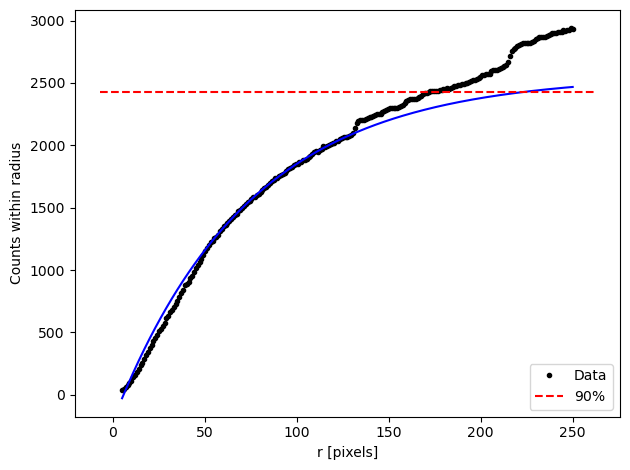

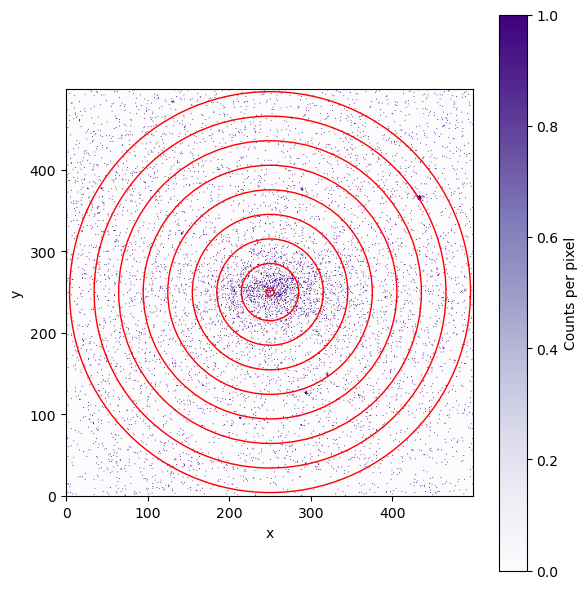

In [226]:
from scipy.optimize import curve_fit

def func(r,a,b,c):
    return a*(1-np.exp(-b*r))+c
data = np.loadtxt("flux_data.txt")
radii = data[:,0]
fluxes = data[:,1]
mask = ((radii<125) & (radii > 50))
res = curve_fit(func, radii[mask], fluxes[mask], p0=(2528, 0.012, 35))[0]

# At $r\to \infty$, this will converge to a+c
# We can consider the radius at which the counts are 95% of the total counts
print(res[0]+res[2])
counts_outer_radius = (res[0]+res[2])*0.95

plt.plot(radii, fluxes, color="black", marker=".", ls="None", label="Data")
plt.plot(radii, func(radii, *res), ls="-", marker="None", color="blue")
plt.hlines(counts_outer_radius, *plt.xlim(), ls="--", color="red", label=r"$90\%$")
plt.legend(loc="lower right")
plt.xlabel("r [pixels]")
plt.ylabel("Counts within radius")
plt.tight_layout()
plt.savefig("counts_radius.pdf")
plt.show()
fig, ax1 = plt.subplots(figsize=(6,6))
im = ax1.imshow(cutout, origin="lower", cmap="Purples", vmax=1)
for r in radii[::30]:
    circle1 = plt.Circle((250,250), r, color='red', fill=False)
    ax1.add_patch(circle1)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Counts per pixel")
#plt.colorbar(im, label="Counts per pixel", ax=ax1)
plt.tight_layout()
plt.savefig("cutout.pdf")
plt.show()

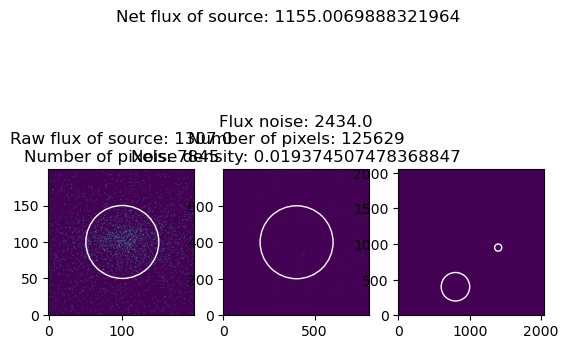

np.float64(1155.0069888321964)

In [111]:
net_flux(img.T, target_pos=(1400,950), noise_pos=(800,400), radius=int(50), noise_radius=200, if_plot=True)

In [188]:
N = 10
scale = (50/60)/N
for i in range(N):
    ri, rf = np.max([0.05, i*scale]), (i+1)*scale
    with open(rf"/Users/ogilbert/Desktop/PhD/Courses/ASTRO532/cluster_assignment/auto_annulus{i}.reg", mode="w") as f:
        f.write(rf"annulus(01:06:28.07,-59:43:10.2,{ri}',{rf}')")

## Read output files

In [ ]:
import re

def read_xspec_results(filename):
    results = {}
    with open(filename, "r") as f:
        text = f.read()

    # kT
    kT_match = re.search(
        r'zbremss\s+kT\s+\w+\s+([\d.Ee+-]+)\s+\+/-\s+([\d.Ee+-]+)', text
    )
    if kT_match:
        results["kT_keV"] = float(kT_match.group(1))
        results["kT_err"] = float(kT_match.group(2))

    # norm with uncertainty
    norm_match = re.search(
        r'zbremss\s+norm\s+([\d.Ee+-]+)\s+\+/-\s+([\d.Ee+-]+)', text
    )
    if norm_match:
        results["norm"] = float(norm_match.group(1))
        results["norm_err"] = float(norm_match.group(2))

    # flux with optional uncertainties
    flux_match = re.search(
        r'Model Flux\s+([\d.Ee+-]+)(?:\s*\+/-\s*([\d.Ee+-]+))?\s+photons\s+\('
        r'([\d.Ee+-]+)(?:\s*\+/-\s*([\d.Ee+-]+))?\s+ergs/cm\^2/s\)',
        text
    )
    if flux_match:
        results["flux_photons"] = float(flux_match.group(1))
        results["flux_photons_err"] = float(flux_match.group(2)) if flux_match.group(2) else None
        results["flux_ergs_cm2_s"] = float(flux_match.group(3))
        results["flux_ergs_cm2_s_err"] = float(flux_match.group(4)) if flux_match.group(4) else None

    return results

if __name__ == "__main__":
    filename = "/Users/ogilbert/Desktop/PhD/Courses/ASTRO532/cluster_assignment/13468/primary/spec_annulus1_fit.txt"
    data = read_xspec_results(filename)
    for key, val in data.items():
        print(f"{key}: {val}")

N = 20
scale = (100/60)/N
rs = []
r_errs = []
for i in range(N):
    ri, rf = np.max([0.05, i*scale]), (i+1)*scale
    rs.append((np.mean([ri,rf])*(u.arcmin)*4.986*(u.kpc/u.arcsec)).to(u.kpc)) # radii in kpc
    r_errs.append(((rf-np.mean([ri,rf]))*(u.arcmin)*4.986*(u.kpc/u.arcsec)).to(u.kpc))

kTs = []
norms = []
fluxes = []
radiis = []
radii_errs = []
kT_errs = []
norm_errs = []
D = ((1874.2*u.Mpc).to(u.cm)).value # Distance to source in cm
print(D)
for i in range(N):
    try:
        filename = rf"/Users/ogilbert/Desktop/PhD/Courses/ASTRO532/cluster_assignment/13468/past_fits/spec_annulus{i}_fit.txt"  # change to your file path
        data = read_xspec_results(filename)
        kTs.append(data["kT_keV"])
        kT_errs.append(data["kT_err"])
        norms.append(data["norm"])
        norm_errs.append(data["norm_err"])
        radiis.append(rs[i].value)
        radii_errs.append(r_errs[i].value)
        fluxes.append(data["flux_ergs_cm2_s"])
    except Exception as e:
        #print(data, data.items(), e)
        pass
R_ins = np.array(radiis)-np.array(radii_errs)
R_outs = np.array(radiis)+np.array(radii_errs)
norms = np.array(norms)
ns = D*np.sqrt(norms/(1E-15*((R_outs*u.kpc.to(u.cm))**3-(R_ins*u.kpc.to(u.cm))**3)))
n_errs = D*np.sqrt(norms/(1E-15*((R_outs*u.kpc.to(u.cm))**3-(R_ins*u.kpc.to(u.cm))**3)))
print(ns)
#n_errs = D*np.sqrt(np.mean(norms)/(1E-15*(R_outs**3-R_ins**3)))
print(len(radiis), len(norms), len(kTs), len(kT_errs), len(norm_errs))


kT_keV: 2.64279
kT_err: 0.60363
norm: 0.00654896
norm_err: 0.00124387
flux_photons: 0.0046803
flux_photons_err: None
flux_ergs_cm2_s: 9.3738e-12
flux_ergs_cm2_s_err: None
5.78317692323112e+27
[0.26217688 0.19059206 0.15850495 0.14992489 0.12393608 0.1266829
 0.16352824 0.10327644 0.09576417 0.07803314 0.0635099  0.05550275
 0.05490339 0.10518426 0.08792192 0.04544371 0.08064064 0.04111055
 0.06823624]
19 19 19 19 19


[ -0.06957455   0.08614628 -55.51526473]
dlnrho/dlnr: [-0.41778733 -0.48886825 -0.53568806 -0.57065824 -0.59858139 -0.62182681
 -0.64173916 -0.6591555  -0.67463245 -0.68855897 -0.70121761 -0.71282009
 -0.72352915 -0.7334726  -0.74275264 -0.7514523  -0.7596399  -0.76737239
 -0.77469772]
[-0.7780222   7.29650803  1.03882984]
dlnT/dlnr: [ 1.66123565  0.86636829  0.34280255 -0.04825386 -0.36050637 -0.62044994
 -0.84312121 -1.03788062 -1.21095265 -1.36668695 -1.50824308 -1.63798856
 -1.75774336 -1.86893668 -1.97271142 -2.06999587 -2.16155431 -2.24802346
 -2.32993945]
61.608203850675224 Myr 30.34605895590068 Gyr


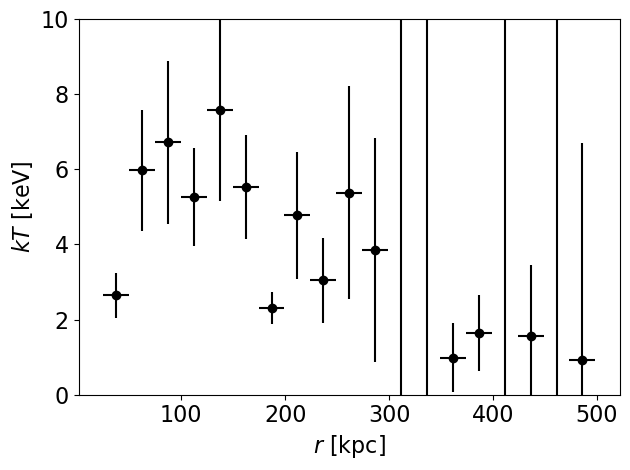

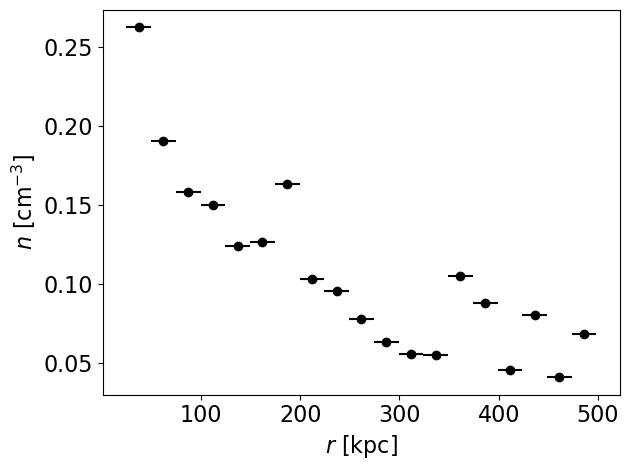

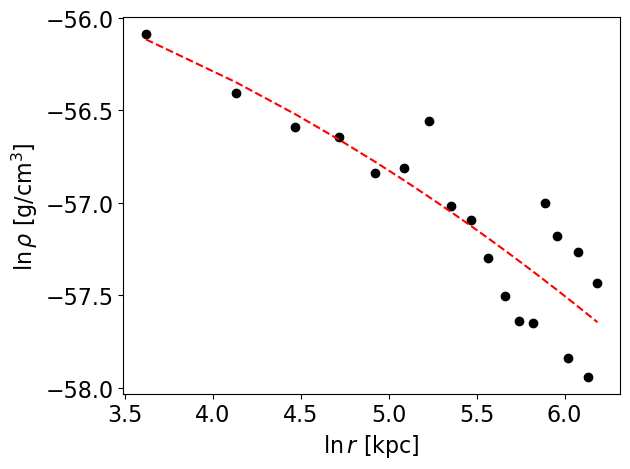

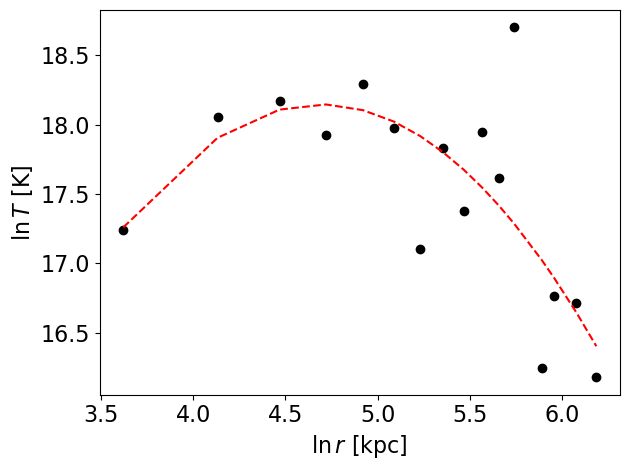

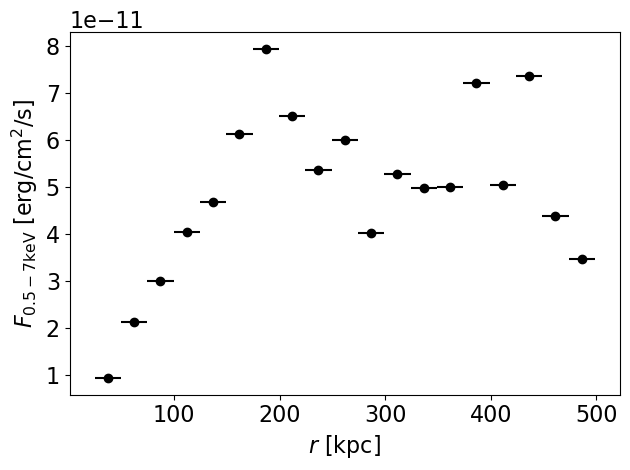

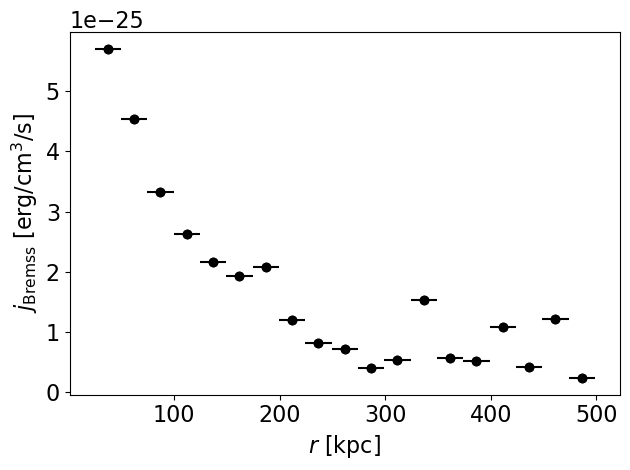

In [356]:
from astropy.constants import G, m_p, k_B, c
import astropy.units as u
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
plt.rc("axes", labelsize=16)
plt.errorbar(radiis, kTs, xerr=radii_errs, yerr=kT_errs, color="black", marker="o", ls="None")
plt.xlabel(r"$r$ [kpc]")
plt.ylabel(r"$kT$ [keV]")
plt.ylim(0,10)
plt.tight_layout()
plt.savefig("temp_profile.pdf")

plt.figure()
plt.errorbar(radiis, ns, xerr=radii_errs, yerr=0*ns, color="black", marker="o", ls="None")
plt.xlabel(r"$r$ [kpc]")
plt.ylabel(r"$n$ $[\mathrm{cm^{-3}}]$")
#plt.ylim(0,30)
plt.tight_layout()
plt.savefig("number_density_profile.pdf")


x, y = np.log(radiis), np.log(((ns/(u.cm**3)*m_p).to(u.g/u.cm**3)).value)

from scipy.optimize import curve_fit
def polynomial(x,a,b,c):
    return x**2*a+b*x+c
def slope(x, params):
    return 2*x*params[0]+params[1]
params, cov = curve_fit(polynomial, x, y)
params_sigs = np.sqrt(np.diag(cov))
dlnrho_dlnr = lambda r: slope(r, params)
print(params)
print("dlnrho/dlnr:",dlnrho_dlnr(np.log(radiis)))
plt.figure()
plt.plot(x, y, color="black", marker="o", ls="None")
plt.plot(x, polynomial(x, *params), color="red", ls="--")
plt.xlabel(r"$\ln r$ [kpc]")
plt.ylabel(r"$\ln \rho$ $[\mathrm{g/cm^{3}}]$")
plt.tight_layout()
plt.savefig("lnplot_rho.pdf")

x, y = np.log(radiis), np.log(((kTs*u.keV/(k_B)).to(u.K)).value)
mask = (y < 20)
x, y = x[mask], y[mask]
params, cov = curve_fit(polynomial, x, y)
params_sigs = np.sqrt(np.diag(cov))
dlnT_dlnr = lambda r: slope(r, params)
print(params)
print("dlnT/dlnr:",dlnT_dlnr(np.log(radiis)))
plt.figure()
plt.plot(x, y, color="black", marker="o", ls="None")
plt.plot(x, polynomial(x, *params), color="red", ls="--")
plt.xlabel(r"$\ln r$ [kpc]")
plt.ylabel(r"$\ln T$ $[\mathrm{K}]$")
plt.tight_layout()
plt.savefig("lnplot_T.pdf")

plt.figure()
plt.errorbar(radiis, fluxes, xerr=radii_errs, yerr=0, color="black", marker="o", ls="None")
plt.xlabel(r"$r$ [kpc]")
plt.ylabel(r"$F_\mathrm{0.5-7keV}$ $[\mathrm{erg/cm^{2}/s}]$")
#plt.ylim(0,30)
plt.tight_layout()
plt.savefig("flux_profile.pdf")


# Cooling time:
kTs_ = np.array(kTs)*u.keV
ns_ = ns/(u.cm**3)
j_bremss = 1.5E-23*ns**2*(((kTs_/k_B).to(u.K).value)/1E8)**(1/2)
j_bremss = j_bremss*(u.erg/u.cm**3/u.s)

t_cool_inner = ns_[0]*kTs_[0]/j_bremss[0]
t_cool_outer = ns_[-1]*kTs_[-2]/j_bremss[-1]
print(t_cool_inner.to(u.Myr), t_cool_outer.to(u.Gyr))

plt.figure()
plt.plot(radiis, j_bremss, color="black", marker="o", ls="None")
plt.errorbar(radiis, j_bremss, xerr=radii_errs, yerr=0*j_bremss, color="black", marker="o", ls="None")
plt.xlabel(r"$r$ [kpc]")
plt.ylabel(r"$j_\mathrm{Bremss}$ $[\mathrm{erg/cm^{3}/s}]$")
#plt.ylim(0,30)
plt.tight_layout()
plt.savefig("emissivity_profile.pdf")

[-7.31288846e+12 -1.43591003e+13 -8.94723952e+12  1.26915519e+12
  1.66607062e+13  2.47683868e+13  1.62561360e+13  4.68207159e+13
  3.88401590e+13  8.57173093e+13  7.41386342e+13  2.59158081e+14
  2.57453180e+15  2.95110023e+13  5.58798200e+13  3.92495446e+15
  6.57985334e+13  9.20659709e+15  4.61633178e+13] solMass
14.79448804665917
mass 13.942181518927935 0.9515477998686532
[ 7.55239510e+00 -1.04941065e+04 -9.61615000e+06  1.39421815e+01]


/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_70903/48701789.py:9: RuntimeWarning: invalid value encountered in log10
  plt.errorbar(radiis, np.log10(Ms.value), xerr=radii_errs, yerr=0, color="black", marker="o", ls="None")
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_70903/48701789.py:16: RuntimeWarning: invalid value encountered in log10
  y = np.log10(Ms.value)
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_70903/48701789.py:13: RuntimeWarning: overflow encountered in exp
  return A / (1 + np.exp(-b*(r - r0))) + c
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_70903/48701789.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  res, cov = curve_fit(logistic_func, x[mask], y[mask], p0=[1, 0.1, 0,0])


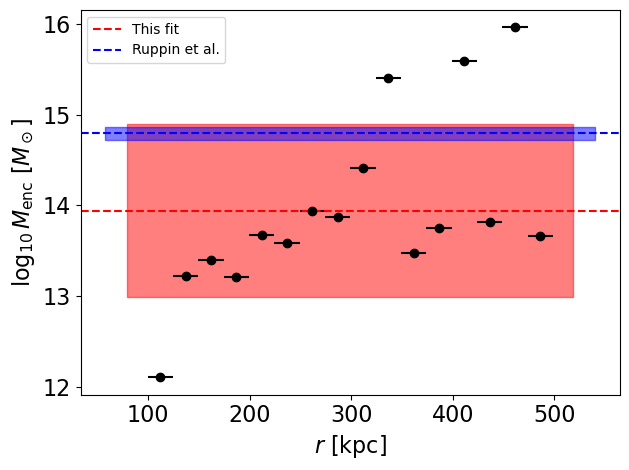

In [358]:

mu = 1
def Mass(kT, R):
    return (-kT*R/(G*mu*m_p)*(dlnrho_dlnr(np.log(R.value)) + dlnT_dlnr(np.log(R.value)))).to(u.Msun)

Ms = Mass(kTs*u.keV, radiis*u.kpc)
print(Ms)

plt.figure()
plt.errorbar(radiis, np.log10(Ms.value), xerr=radii_errs, yerr=0, color="black", marker="o", ls="None")
plt.xlabel(r"$r$ [kpc]")
plt.ylabel(r"$\log_{10}M_\mathrm{enc}$ $[M_\odot]$")
def logistic_func(r, A, b, r0, c):
    return A / (1 + np.exp(-b*(r - r0))) + c

x = np.array(radiis)#.to(u.kpc).value   # or whichever unit you want
y = np.log10(Ms.value)
mask = ((~np.isnan(y)))
print(np.log10(6.23*1E14))
res, cov = curve_fit(logistic_func, x[mask], y[mask], p0=[1, 0.1, 0,0])
print("mass", np.nanmean(y), np.nanstd(y))
x_fit = np.linspace(np.min(x), np.max(x), 200)
print(res)
plt.fill_between(plt.xlim(), np.nanmean(y)-np.nanstd(y), np.nanmean(y)+np.nanstd(y), color="red", alpha=0.5)
plt.axhline(np.nanmean(y), color="red", ls="--", label="This fit")
A = 6.23*1E14
sigA = 1.05*1E14
f = np.log10(A)
sigf = sigA/(A*np.log(10))
plt.fill_between(plt.xlim(), f-sigf, f+sigf, color="blue", alpha=0.5)
plt.axhline(f, color="blue", ls="--", label="Ruppin et al.")
#plt.ylim(0,30)
plt.legend()
plt.tight_layout()
plt.savefig("mass_profile.pdf")